# 自注意力

In [45]:
import torch
from torch import nn
from d2l import torch as d2l
import math

In [46]:
def masked_softmax(X,valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
    X= d2l.sequence_mask(X.reshape(-1,shape[-1]),valid_lens,value=1e-6)
    return nn.functional.softmax(X.reshape(shape),dim=1)

In [47]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4780, 0.2864, 0.5000, 0.5000],
         [0.5220, 0.7136, 0.5000, 0.5000]],

        [[0.5063, 0.5860, 0.4996, 0.5000],
         [0.4937, 0.4140, 0.5004, 0.5000]]])

## 注意力类

In [48]:
class DotProductAttention(nn.Module):
    def __init__(self,dropout,**kwargs):
        super(DotProductAttention,self).__init__(**kwargs)
        self.dropout=nn.Dropout(dropout)

    def forward(self,queries,keys,values,valid_lens=None):
        d=queries.shape[-1]
        scores=torch.bmm(queries,keys.transpose(1,2)) / math.sqrt(d)
        self.addention_weights=masked_softmax(scores,valid_lens)
        return torch.bmm(self.dropout(self.addention_weights),values)


In [108]:
class ClassicAttention(nn.Module):
    def __init__(self,key_size,query_size,num_hiddens,dropout,**kwargs):
        super(ClassicAttention,self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self,queries,keys,values,valid_lens=None):
        queries,keys=self.W_q(queries),self.W_k(keys)
        scores=torch.bmm(queries,keys.transpose(1,2))
        self.attenation_weights=masked_softmax(scores,valid_lens)
        values=self.w_v(values)
        return torch.bmm(nn.functional.softmax(self.attenation_weights),values)

In [123]:
keys =torch.ones((2, 1, 32))
values = torch.normal(0, 1, (2, 1, 32))
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
valid_lens = torch.tensor([2, 6])
queries = torch.normal(0, 1, (2, 1, 32))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

attention_classic = ClassicAttention(num_hiddens,num_hiddens,num_hiddens,dropout=dropout)
attention_classic.eval()
attention_classic(queries, keys, values, valid_lens)

/tmp/ipykernel_2708/3214599407.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.bmm(nn.functional.softmax(self.attenation_weights),values)


tensor([[[-0.0188]],

        [[-0.0450]]], grad_fn=<BmmBackward0>)

torch.Size([1, 10, 128])

In [60]:
x=torch.rand(10,64,52)
state=torch.rand(2,64,32)
context=state[-1].repeat(x.shape[0],1,1)
print(context.shape)
X_and_context = torch.cat((x, context), 2)
print(X_and_context.shape)

torch.Size([10, 64, 32])
torch.Size([10, 64, 84])


## Bahdanau 注意力
1. 编码器在所有时间步的最终层隐状态，将作为注意力的键和值；
2. 上一时间步的编码器全层隐状态，将作为初始化解码器的隐状态；
3. 编码器有效长度（排除在注意力池中填充词元）

In [67]:
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    @property
    def attention_weights(self):
        raise NotImplementedError

**修改为LSTM**


In [85]:

class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器

    Defined in :numref:`sec_seq2seq`"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,net=None,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        if isinstance(net,str):
            if net =='GRU':

                self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                            dropout=dropout)
            elif net =='LSTM':
                self.rnn= nn.LSTM(embed_size,num_hiddens,num_layers,dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        if isinstance(self.rnn,nn.GRU):

            output, state = self.rnn(X)
            return output, state
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        elif isinstance(self.rnn,nn.LSTM):
            output, state = self.rnn(X)
            return output, state


In [129]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
        dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(
        embed_size + num_hiddens, num_hiddens, num_layers,
        dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, (hidden_state,C_state) = enc_outputs
        return (outputs.permute(1, 0, 2), (hidden_state,C_state), enc_valid_lens)   
    def forward(self, X, state):
    # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
    # hidden_state的形状为(num_layers,batch_size,
    # num_hiddens)
        enc_outputs, (hidden_state,C_state), enc_valid_lens = state
        
    # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
        # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
        # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)   # 1.编码器在所有时间步的最终层隐状态，将作为注意力的键和值
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, (hidden_state,C_state) = self.rnn(x.permute(1,0, 2), (hidden_state,C_state))   #2.上一时间步的编码器全层隐状态，将作为初始化解码器的隐状态；
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
            # 全连接层变换后，outputs的形状为
            # (num_steps,batch_size,vocab_size)
            outputs = self.dense(torch.cat(outputs, dim=0))
            return outputs.permute(1, 0, 2), [enc_outputs, (hidden_state,C_state),
            enc_valid_lens]
    @property
    def attention_weights(self):
        return self._attention_weights


loss 0.915, 2417.7 tokens/sec on cuda:0


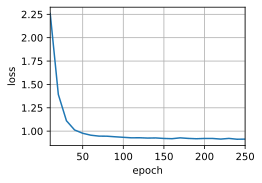

In [130]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 1
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
len(src_vocab), embed_size, num_hiddens, num_layers, net="LSTM",dropout=dropout)
decoder = Seq2SeqAttentionDecoder(
len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [72]:
'''
GRU 
AdditiveAttention
loss 0.919, 2477.0 tokens/sec on cuda:0
LSTM 
AdditiveAttention
loss 0.921, 2858.3 tokens/sec on cuda:0
GRU
DotProductAttention

LSTM 
DotProductAttention
loss 0.916, 2940.4 tokens/sec on cuda:0

'''


SyntaxError: invalid syntax (2631045379.py, line 1)

## 多头注意力

## transformer